In [2]:

import os
import warnings
from argparse import ArgumentParser
import matplotlib.patches as patches
import torch
from tqdm import tqdm
import cv2
from torch.utils import data
# 개별 json 라벨 파일을 이용해 학습 데이터 리스트 생성
from glob import glob
import xml.etree.ElementTree as ET
from xml.dom import minidom
import os
from nets import nn
from utils import util
from utils.dataset import Dataset
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import random
import openslide
import copy
import random
from time import time

import math
import numpy
import torch
import torchvision
from torch.nn.functional import cross_entropy
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
params={'names':{0: 'class_0', 1: 'class_1', 2: 'class_2',3: 'class_3'}}

device: cuda:0


In [3]:
save_dir='../../model/her2_cell_level_yolov11_multi_scale/'
model = nn.yolo_v11_m(len(params['names'])).to(device)
checkpoint_path = os.path.join(save_dir, 'best_model.pt')
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
def wh2xy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else numpy.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y
   
def non_max_suppression(outputs, confidence_threshold=0.001, iou_threshold=0.65, class_thresholds=None):
    """
    빠른 클래스별 NMS - 성능 최적화 버전
    """
    max_wh = 7680
    max_det = 300
    max_nms = 30000

    bs = outputs.shape[0]
    nc = outputs.shape[1] - 4
    
    # 빠른 필터링을 위해 가장 낮은 threshold 사용
    min_conf = confidence_threshold
    if class_thresholds:
        min_conf = min(min(class_thresholds.values()), confidence_threshold)
    
    # 전체 confidence가 낮은 것들 먼저 제거
    xc = outputs[:, 4:4 + nc].amax(1) > min_conf
    
    output = [torch.zeros((0, 6), device=outputs.device)] * bs
    
    for xi, x in enumerate(outputs):  # image index, image inference
        x = x.transpose(0, -1)[xc[xi]]
        
        if not x.shape[0]:
            continue

        # 박스와 클래스 분리
        box, cls = x.split((4, nc), 1)
        box = wh2xy(box)
        
        # 각 검출의 최고 클래스와 confidence 찾기
        conf, j = cls.max(1, keepdim=True)
        x = torch.cat((box, conf, j.float()), 1)
        
        # 클래스별 threshold 적용 (간단한 방식)
        if class_thresholds:
            keep = torch.zeros(x.shape[0], dtype=torch.bool, device=x.device)
            for i, detection in enumerate(x):
                class_id = int(detection[5].item())
                threshold = class_thresholds.get(class_id, confidence_threshold)
                if detection[4].item() >= threshold:
                    keep[i] = True
            x = x[keep]
        else:
            x = x[x[:, 4] > confidence_threshold]
        
        if not x.shape[0]:
            continue
            
        # confidence로 정렬하고 상위 max_nms개만 유지
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        
        # 빠른 NMS - PyTorch 내장 함수 사용
        c = x[:, 5:6] * max_wh  # 클래스별 offset
        boxes = x[:, :4] + c
        scores = x[:, 4]
        
        # NMS 적용
        keep = torchvision.ops.nms(boxes, scores, iou_threshold)
        if keep.shape[0] > max_det:
            keep = keep[:max_det]
        
        output[xi] = x[keep]
    
    return output
    
def pred_patch(torch_patch, model, magnification):
    model.eval()
    
    # 클래스별 개별 confidence threshold 설정
    class_thresholds = {
        0: 0.3,  # Her2 class0 cell
        1: 0.3,  # Her2 class1 cell
        2: 0.3,  # Her2 class2 cell
        3: 0.3   # Her2 class3 cell
    }
    
    class_0_tumor = []
    class_1_tumor = []
    class_2_tumor = []
    class_3_tumor = []
    
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            pred = model(torch_patch)
        
        # 빠른 NMS 적용
        results = non_max_suppression(pred, confidence_threshold=0.3, 
                                    iou_threshold=0.1, class_thresholds=class_thresholds)
        
        if len(results[0]) > 0:
            # 벡터화된 처리로 속도 향상
            detections = results[0]
            xyxy = detections[:, :4]
            confs = detections[:, 4]
            cls_ids = detections[:, 5]
            
            # 중심점 계산 (벡터화)
            centers_x = (xyxy[:, 0] + xyxy[:, 2]) / 2
            centers_y = (xyxy[:, 1] + xyxy[:, 3]) / 2
            
            # 실제 좌표 계산
            actual_x = centers_x * magnification
            actual_y = centers_y * magnification
            
            # 클래스별로 분리 (벡터화)
            for i in range(len(detections)):
                cls_id = int(cls_ids[i].item())
                cell_data = {
                    'x': actual_x[i].item(), 
                    'y': actual_y[i].item(), 
                    'cls_id': cls_id,
                    'confidence': confs[i].item()
                }
                
                if cls_id == 0:
                    class_0_tumor.append(cell_data)
                elif cls_id == 1:
                    class_1_tumor.append(cell_data)
                elif cls_id == 2:
                    class_2_tumor.append(cell_data)
                else:
                    class_3_tumor.append(cell_data)
    
    return class_0_tumor, class_1_tumor, class_2_tumor, class_3_tumor

In [4]:
def create_asap_xml(class_0_tumor, class_1_tumor, class_2_tumor, class_3_tumor, output_path):
    """
    세포 검출 결과를 ASAP XML 형식으로 저장하는 함수
    
    Args:
        class_0_tumor: Her2 class 0 tumor cells 리스트
        class_1_tumor: Her2 class 1 tumor cells 리스트
        class_2_tumor: Her2 class 2 tumor cells 리스트
        class_3_tumor: Her2 class 3 tumor cells 리스트 
        output_path: 저장할 XML 파일 경로
    """
    class_list=['class_0','class_1+','class_2+','class_3+']
    color_list=['#00FF00','#FFFF00','#0000FF','#FF0000'] 
    # 루트 엘리먼트 생성
    root = ET.Element("ASAP_Annotations")
    
    # Annotations 엘리먼트 생성
    annotations = ET.SubElement(root, "Annotations")
    
    annotation_id = 0
    
    # Negative tumor cells 추가 (빨간색)
    for cell in class_0_tumor:
        annotation = ET.SubElement(annotations, "Annotation")
        annotation.set("Name", f"Annotation {annotation_id}")
        annotation.set("Type", "Dot")
        annotation.set("PartOfGroup", class_list[0])
        annotation.set("Color", color_list[0])  # 초록색
        
        coordinates = ET.SubElement(annotation, "Coordinates")
        coordinate = ET.SubElement(coordinates, "Coordinate")
        coordinate.set("Order", "0")
        coordinate.set("X", str(float(cell['x'])))
        coordinate.set("Y", str(float(cell['y'])))
        
        annotation_id += 1
    
    # Positive tumor cells 추가 (파란색)
    for cell in class_1_tumor:
        annotation = ET.SubElement(annotations, "Annotation")
        annotation.set("Name", f"Annotation {annotation_id}")
        annotation.set("Type", "Dot")
        annotation.set("PartOfGroup", class_list[1])
        annotation.set("Color", color_list[1])  # 노란색

        coordinates = ET.SubElement(annotation, "Coordinates")
        coordinate = ET.SubElement(coordinates, "Coordinate")
        coordinate.set("Order", "0")
        coordinate.set("X", str(float(cell['x'])))
        coordinate.set("Y", str(float(cell['y'])))
        
        annotation_id += 1
    
    for cell in class_2_tumor:
        annotation = ET.SubElement(annotations, "Annotation")
        annotation.set("Name", f"Annotation {annotation_id}")
        annotation.set("Type", "Dot")
        annotation.set("PartOfGroup", class_list[2])
        annotation.set("Color", color_list[2])  # 파란색

        coordinates = ET.SubElement(annotation, "Coordinates")
        coordinate = ET.SubElement(coordinates, "Coordinate")
        coordinate.set("Order", "0")
        coordinate.set("X", str(float(cell['x'])))
        coordinate.set("Y", str(float(cell['y'])))
        
        annotation_id += 1
    for cell in class_3_tumor:
        annotation = ET.SubElement(annotations, "Annotation")
        annotation.set("Name", f"Annotation {annotation_id}")
        annotation.set("Type", "Dot")
        annotation.set("PartOfGroup", class_list[3])
        annotation.set("Color", color_list[3])  # 빨간색

        coordinates = ET.SubElement(annotation, "Coordinates")
        coordinate = ET.SubElement(coordinates, "Coordinate")
        coordinate.set("Order", "0")
        coordinate.set("X", str(float(cell['x'])))
        coordinate.set("Y", str(float(cell['y'])))
        
        annotation_id += 1
    
    
    # AnnotationGroups 엘리먼트 생성
    annotation_groups = ET.SubElement(root, "AnnotationGroups")


    group1 = ET.SubElement(annotation_groups, "Group")
    group1.set("Name", class_list[0])
    group1.set("PartOfGroup", "None")
    group1.set("Color", color_list[0])
    attributes1 = ET.SubElement(group1, "Attributes")
    
    # Positive Tumor 그룹
    group2 = ET.SubElement(annotation_groups, "Group")
    group2.set("Name", class_list[1])
    group2.set("PartOfGroup", "None")
    group2.set("Color", color_list[1])
    attributes2 = ET.SubElement(group2, "Attributes")
    
    group3 = ET.SubElement(annotation_groups, "Group")
    group3.set("Name", class_list[2])
    group3.set("PartOfGroup", "None")
    group3.set("Color", color_list[2])
    attributes3 = ET.SubElement(group3, "Attributes")       
    
    group4 = ET.SubElement(annotation_groups, "Group")
    group4.set("Name", class_list[3])
    group4.set("PartOfGroup", "None")
    group4.set("Color", color_list[3])
    attributes4 = ET.SubElement(group4, "Attributes")   
    
    
    # XML을 예쁘게 포맷팅하여 저장
    rough_string = ET.tostring(root, 'unicode')
    reparsed = minidom.parseString(rough_string)
    pretty_xml = reparsed.toprettyxml(indent="	")
    
    # <?xml version... 라인을 원하는 형태로 수정
    lines = pretty_xml.split('\n')
    lines[0] = '<?xml version="1.0"?>'
    pretty_xml = '\n'.join(lines[1:])  # 빈 라인 제거
    
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(pretty_xml)
    
def create_directory(path, exist_ok=True):
    """
    디렉토리를 생성하는 함수
    
    Args:
        path: 생성할 디렉토리 경로
        exist_ok: 디렉토리가 이미 존재해도 에러를 발생시키지 않음
    """
    os.makedirs(path, exist_ok=exist_ok)

In [ ]:
import pyvips
image_path='../../data/validation_patch_her2/images/'
label_path='../../data/validation_patch_her2/labels/'
create_directory(image_path,exist_ok=True)
create_directory(label_path,exist_ok=True)

slide_path=glob('../../data/BR_her2/*.tiff')
image_size=512 # 모델 입력 크기
origin_mpp=0.25
output_mpp=0.5
original_size=int(image_size*output_mpp/origin_mpp) #1122
magnification=original_size/image_size
count=0
for i in range(len(slide_path)):

    file_name=os.path.basename(slide_path[i]).split('.')[0]
    slide=openslide.OpenSlide(slide_path[i])
    thumbnail=slide.get_thumbnail((slide.dimensions[0]//64, slide.dimensions[1]//64))
    slide = pyvips.Image.new_from_file(slide_path[i])

    thumb_mask=cv2.threshold(255-np.array(thumbnail.convert('L')),30,255,cv2.THRESH_BINARY)[1]
    thumb_mask=cv2.morphologyEx(thumb_mask,cv2.MORPH_CLOSE,np.ones((15,15),np.uint8))
    thumb_mask=cv2.morphologyEx(thumb_mask,cv2.MORPH_OPEN,np.ones((5,5),np.uint8))
    
    # 방법 1: 미리 계산된 패치 수로 사전 할당
    total_patches = (slide.width//original_size-1) * (slide.height//original_size-1)
    estimated_cells_per_patch = 50  # 패치당 예상 세포 수 (조정 가능)
    
    # 사전 할당된 리스트 대신 임시 리스트들 사용
    class_0_batches = []
    class_1_batches = []
    class_2_batches = []
    class_3_batches = []

    for patch_row in tqdm(range(slide.width//image_size-1)):
        for patch_col in range(slide.height//image_size-1):
            if np.sum(thumb_mask[(patch_col*image_size)//64:((patch_col+1)*image_size)//64,(patch_row*image_size)//64:((patch_row+1)*image_size)//64])>0:
                count+=1
                patch=slide.crop(patch_row*image_size, patch_col*image_size, image_size, image_size)
                patch=np.ndarray(buffer=patch.write_to_memory(),
                            dtype=np.uint8,
                            shape=[patch.height, patch.width, patch.bands])
                patch=cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
                torch_patch=torch.from_numpy(np.array(patch)[:,:,:3]).permute(2,0,1).unsqueeze(0).float()/255.
                torch_patch=torch_patch.to(device)
                temp_class_0_tumor, temp_class_1_tumor, temp_class_2_tumor, temp_class_3_tumor = pred_patch(torch_patch, model, 1)
                if len(temp_class_0_tumor)!=0 or len(temp_class_1_tumor)!=0 or len(temp_class_2_tumor)!=0 or len(temp_class_3_tumor)!=0:
                    cv2.imwrite(image_path+file_name+'_'+str(patch_row)+'_'+str(patch_col)+'.png',patch)
                    create_asap_xml(temp_class_0_tumor, temp_class_1_tumor, temp_class_2_tumor, temp_class_3_tumor, label_path+file_name+'_'+str(patch_row)+'_'+str(patch_col)+'.xml')


 11%|█         | 12/107 [00:04<00:38,  2.49it/s]Exception ignored from cffi callback <function _log_handler_callback at 0x7f87821d8680>:
Traceback (most recent call last):
  File "/home/work/.local/lib/python3.12/site-packages/pyvips/__init__.py", line 149, in _log_handler_callback
    def _log_handler_callback(domain, level, message, user_data):

KeyboardInterrupt: 
Exception ignored from cffi callback <function _log_handler_callback at 0x7f87821d8680>:
Traceback (most recent call last):
  File "/home/work/.local/lib/python3.12/site-packages/pyvips/__init__.py", line 149, in _log_handler_callback
    def _log_handler_callback(domain, level, message, user_data):

KeyboardInterrupt: 
 17%|█▋        | 18/107 [00:18<02:07,  1.43s/it]

In [7]:
patch_path='../../data/validation_patch_her2/images/BRCA-00259-I-HR-01_12_26.png'
label_path='../../data/validation_patch_her2/labels/BRCA-00259-I-HR-01_12_26.xml'

=== Her2 세포 검출 결과 시각화 ===
이미지 로딩 완료: BRCA-00259-I-HR-01_12_26.png
이미지 크기: (512, 512, 3)
XML 로딩 완료: BRCA-00259-I-HR-01_12_26.xml
  Class 0 (class_0): 0개 세포
  Class 1 (class_1+): 0개 세포
  Class 2 (class_2+): 0개 세포
  Class 3 (class_3+): 6개 세포


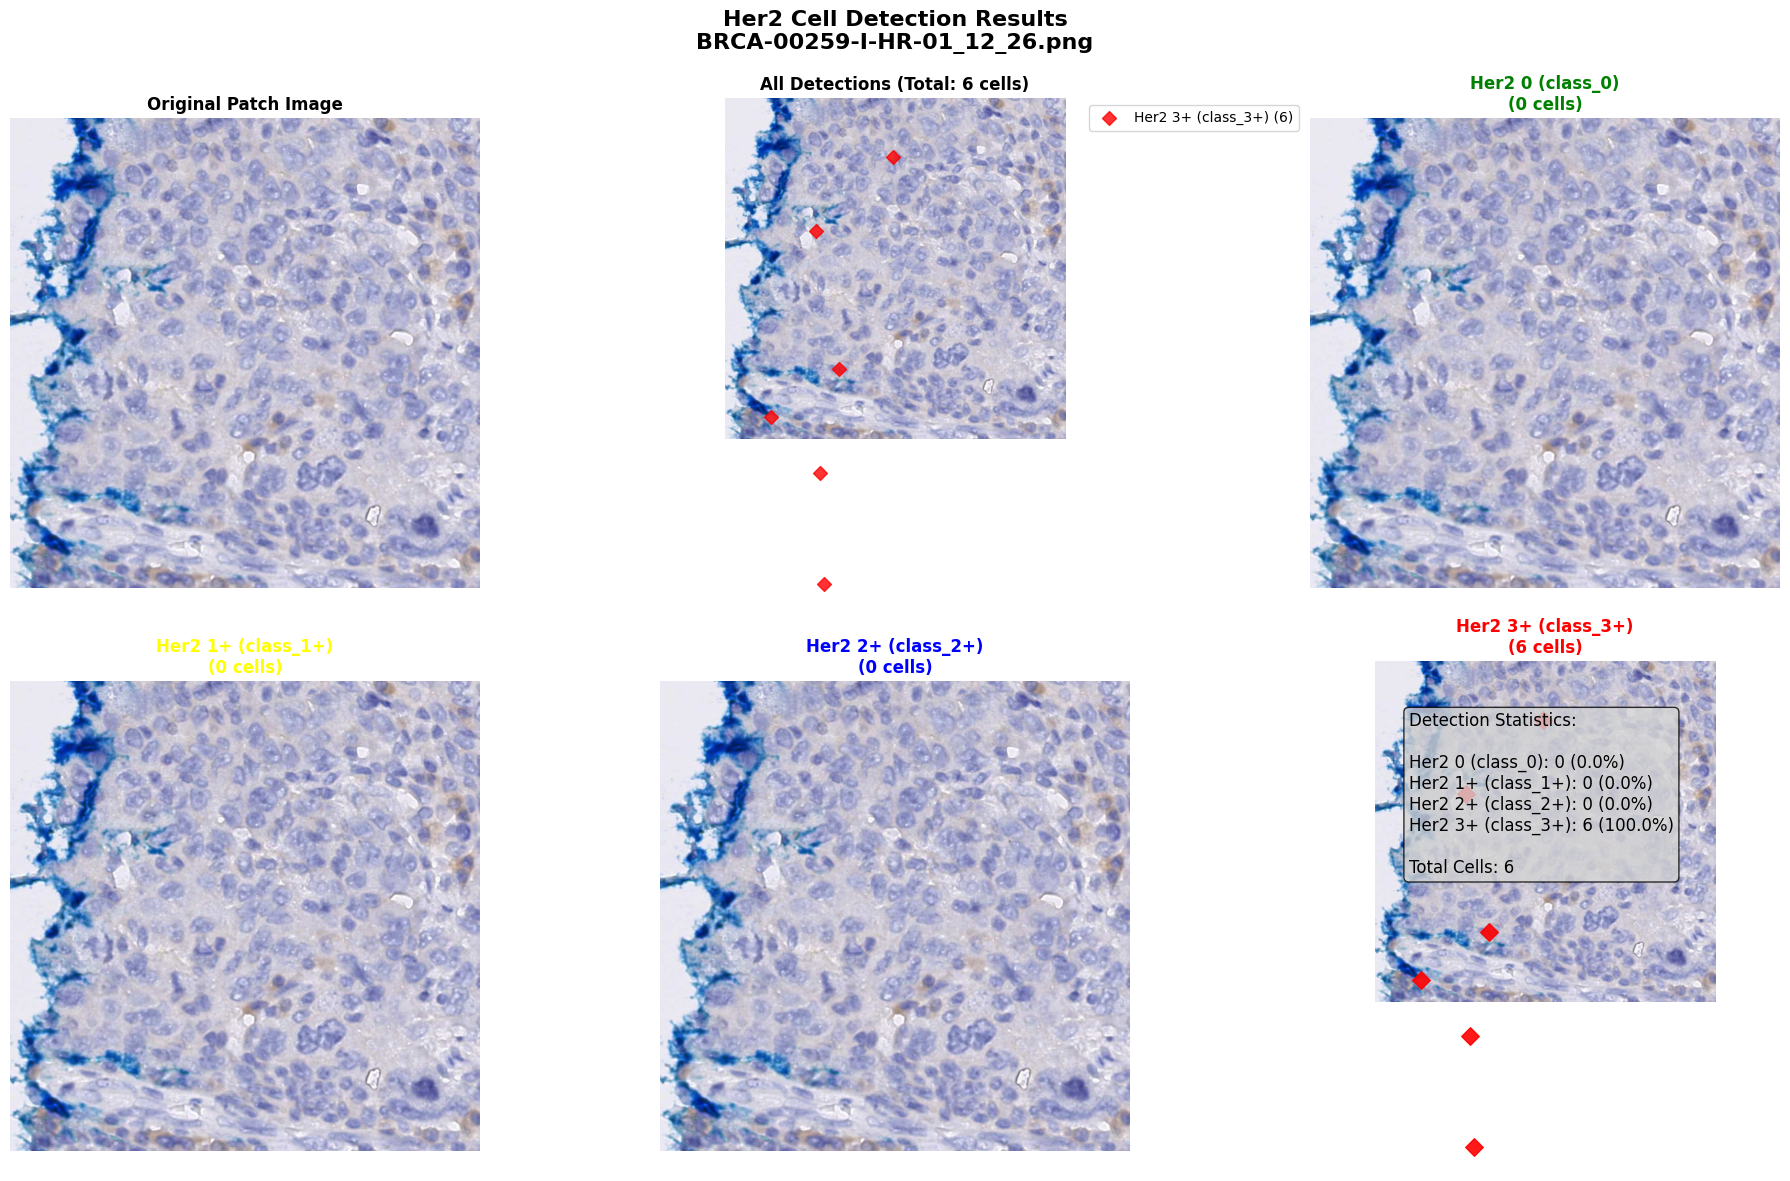

In [8]:
# XML 파일에서 검출된 세포 좌표를 읽어오는 함수
def read_xml_annotations(xml_path):
    """
    ASAP XML 파일에서 세포 검출 좌표를 읽어오는 함수
    
    Args:
        xml_path: XML 파일 경로
        
    Returns:
        dict: 클래스별 세포 좌표 딕셔너리
    """
    annotations = {0: [], 1: [], 2: [], 3: []}
    class_names = ['class_0', 'class_1+', 'class_2+', 'class_3+']
    
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        for annotation in root.find('Annotations').findall('Annotation'):
            group_name = annotation.get('PartOfGroup')
            if group_name in class_names:
                class_id = class_names.index(group_name)
                
                coord = annotation.find('Coordinates').find('Coordinate')
                x = float(coord.get('X'))
                y = float(coord.get('Y'))
                
                annotations[class_id].append({'x': x, 'y': y})
        
        print(f"XML 로딩 완료: {os.path.basename(xml_path)}")
        for i in range(4):
            print(f"  Class {i} ({class_names[i]}): {len(annotations[i])}개 세포")
            
    except Exception as e:
        print(f"XML 파일 읽기 오류: {e}")
        
    return annotations

# 패치 이미지와 검출 결과 시각화
def visualize_patch_with_detections(image_path, xml_path):
    """
    패치 이미지와 검출된 세포를 함께 시각화하는 함수
    
    Args:
        image_path: 패치 이미지 경로
        xml_path: XML 라벨 파일 경로
    """
    # 이미지 로드
    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(f"이미지 로딩 완료: {os.path.basename(image_path)}")
        print(f"이미지 크기: {image_rgb.shape}")
    else:
        print(f"이미지 파일을 찾을 수 없습니다: {image_path}")
        return
    
    # XML 어노테이션 로드
    if os.path.exists(xml_path):
        annotations = read_xml_annotations(xml_path)
    else:
        print(f"XML 파일을 찾을 수 없습니다: {xml_path}")
        return
    
    # 시각화 설정
    class_names = ['Her2 0 (class_0)', 'Her2 1+ (class_1+)', 'Her2 2+ (class_2+)', 'Her2 3+ (class_3+)']
    colors = ['green', 'yellow', 'blue', 'red']
    markers = ['o', 's', '^', 'D']  # 원, 사각형, 삼각형, 다이아몬드
    
    # 서브플롯 생성
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Her2 Cell Detection Results\n{os.path.basename(image_path)}', fontsize=16, fontweight='bold')
    
    # 1. 원본 이미지
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title('Original Patch Image', fontweight='bold')
    axes[0, 0].axis('off')
    
    # 2. 전체 검출 결과
    axes[0, 1].imshow(image_rgb)
    total_cells = 0
    for class_id in range(4):
        cells = annotations[class_id]
        if len(cells) > 0:
            x_coords = [cell['x'] for cell in cells]
            y_coords = [cell['y'] for cell in cells]
            axes[0, 1].scatter(x_coords, y_coords, c=colors[class_id], 
                             marker=markers[class_id], s=50, alpha=0.8, 
                             label=f"{class_names[class_id]} ({len(cells)})")
            total_cells += len(cells)
    
    axes[0, 1].set_title(f'All Detections (Total: {total_cells} cells)', fontweight='bold')
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 1].axis('off')
    
    # 3. 클래스별 개별 시각화
    for class_id in range(4):
        row = (class_id + 2) // 3
        col = (class_id + 2) % 3
        
        axes[row, col].imshow(image_rgb)
        cells = annotations[class_id]
        
        if len(cells) > 0:
            x_coords = [cell['x'] for cell in cells]
            y_coords = [cell['y'] for cell in cells]
            axes[row, col].scatter(x_coords, y_coords, c=colors[class_id], 
                                 marker=markers[class_id], s=80, alpha=0.9)
        
        axes[row, col].set_title(f'{class_names[class_id]}\n({len(cells)} cells)', 
                               fontweight='bold', color=colors[class_id])
        axes[row, col].axis('off')
    
    # 마지막 빈 서브플롯에 통계 정보 표시
    axes[1, 2].axis('off')
    stats_text = "Detection Statistics:\n\n"
    for class_id in range(4):
        count = len(annotations[class_id])
        percentage = (count / total_cells * 100) if total_cells > 0 else 0
        stats_text += f"{class_names[class_id]}: {count} ({percentage:.1f}%)\n"
    
    stats_text += f"\nTotal Cells: {total_cells}"
    axes[1, 2].text(0.1, 0.9, stats_text, transform=axes[1, 2].transAxes, 
                   fontsize=12, verticalalignment='top', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return annotations, total_cells

# 실행
print("=== Her2 세포 검출 결과 시각화 ===")
annotations, total_count = visualize_patch_with_detections(patch_path, label_path)

In [ ]:
# 간단한 시각화 버전
def simple_visualization(image_path, xml_path):
    """
    간단한 패치 이미지와 검출 결과 시각화
    """
    # 이미지 로드
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # XML 로드
    annotations = read_xml_annotations(xml_path)
    
    # 시각화
    plt.figure(figsize=(12, 6))
    
    # 원본 이미지
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original Patch')
    plt.axis('off')
    
    # 검출 결과 오버레이
    plt.subplot(1, 2, 2)
    plt.imshow(image_rgb)
    
    colors = ['green', 'yellow', 'blue', 'red']
    class_names = ['Her2 0', 'Her2 1+', 'Her2 2+', 'Her2 3+']
    
    for class_id in range(4):
        cells = annotations[class_id]
        if len(cells) > 0:
            x_coords = [cell['x'] for cell in cells]
            y_coords = [cell['y'] for cell in cells]
            plt.scatter(x_coords, y_coords, c=colors[class_id], 
                       s=30, alpha=0.8, label=f"{class_names[class_id]} ({len(cells)})")
    
    plt.title('Detection Results')
    plt.legend()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 간단한 버전도 실행
print("\n=== 간단한 시각화 버전 ===")
simple_visualization(patch_path, label_path)